In [9]:
# 为方便大家理解和修改代码，故将变量和函数均以中文命名
# 运行代码需安装 numpy、matplotlib、ipython 库
# 强烈建议使用 jupyter notebook 运行代码
# 需要浅显易懂的Python教程，欢迎关注公众号 Crossin的编程教室 （crossincode）
# 此代码中的疑问可来公众号里讨论

# 设定参数
区域大小 = 100
总人口数 = 100000
医院床位 = 2000
方舱床位 = 10000

潜伏期分布 = (5, 2)
发病期分布 = (10, 3)
传染起始日 = -3
传播概率 = 0.9
重症概率 = 0.01
病亡概率 = 0.01
救治概率 = 0.95
免疫概率 = 0.1

防控力度 = 0.1
出行意愿 = 0.9
接触比例 = 0.9
入院意愿 = 0.1
进方舱概率 = 0.99
常住区域概率 = 0.8
周边出行概率 = 0.95

重复感染 = True
随机新增感染 = True
整体防控 = True
警戒人数 = 1000 if 整体防控 else 100000
精准防控 = True
流调准确率 = 0.3
流调天数 = 7
隔离天数 = 14

资源总量 = 4000000
模拟天数 = 100

LOG_LEVEL = 0    # 调试信息级别，0为最少输出
ExpNo = 8        # 实验ID，用来生成文件名

In [10]:
import random
import numpy as np
import matplotlib.pyplot as plt

总人员列表 = []
住院人员列表 = []
方舱人员列表 = []
病亡人员列表 = []

区域分布列表 = [[[] for i in range(区域大小)] for j in range(区域大小)]

if LOG_LEVEL >= 2:
    ttt=0

class 人():
    def __init__(self, i):
        self.uid = i
        self.x, self.y = self.随机位置()
        self.常住区域 = set()
        self.常住区域数量 = random.randint(3, 6)
        区域分布列表[self.x][self.y].append(self)
        self.常住区域.add((self.x, self.y))
        self.已感染 = False
        self.传染性 = False
        self.免疫 = random.random() < 免疫概率
        self.已入院 = False
        self.已进方舱 = False
        self.隔离中 = False
        self.身体状况 = '健康'
        self.感染后天数 = 0
        self.潜伏期 = 0
        self.发病期 = 0
        self.传染期 = 0
        self.应隔离天数 = 0
        self.密接人群 = []
        self.当日密接人群 = []
        self.当日出行 = False

        if LOG_LEVEL >= 2:
            self.his = []
            self.hit = None
            self.hitt = 0
            self.source = None
        
    def 随机位置(self):
        # 80%人分布在25%区域
        L = int(0.25 * 区域大小)
        if random.random() < 0.8:
            px = random.randint(L, 区域大小-L)
            py = random.randint(L, 区域大小-L)
        else:
            px = random.randint(0, 区域大小-1)
            py = random.randint(0, 区域大小-1)
        return px, py
    
    def 更新位置(self, in_his=False):
        区域分布列表[self.x][self.y].remove(self)
        if in_his:
            # 在常住区域移动
            pos = random.choice(list(self.常住区域))
        else:
            # 去新区域
            if random.random() < 周边出行概率:
                # 在周边九宫格移动
                off_x = random.randint(-1, 1)
                off_y = random.randint(-1, 1)
                pos = (max(min(self.x + off_x, 区域大小-1), 0), max(min(self.y + off_y, 区域大小-1), 0))
            else:
                pos = self.随机位置()
        self.x, self.y = pos
        区域分布列表[self.x][self.y].append(self)
        if len(self.常住区域) < self.常住区域数量:
            self.常住区域.add((self.x, self.y))

        
    def 出行(self):
        if not self.已入院 and not self.已进方舱 and not self.隔离中 and self.身体状况 not in ['重症'] and random.random() < 出行意愿:
            if len(self.常住区域) < self.常住区域数量:
                self.更新位置()
            else:
                if random.random() < 常住区域概率:
                    # 在常住区域移动
                    self.更新位置(True)
                else:
                    # 去新区域
                    self.更新位置()
            self.当日出行 = True
            global 资源总量
            资源总量 += 1
        else:
            self.当日出行 = False

        if LOG_LEVEL >= 2:
            self.his.append((self.x, self.y) if self.当日出行 else ()) 


    def 被传染(self, s=None):
        self.已感染 = True
        self.身体状况 = '潜伏'
        self.感染后天数 = 0
        self.潜伏期 = random.gauss(潜伏期分布[0], 潜伏期分布[1])
        self.发病期 = self.潜伏期 + random.gauss(发病期分布[0], 发病期分布[1])
        self.传染期 = self.潜伏期 + 传染起始日
        
        if LOG_LEVEL >= 2:
            self.hit = (self.x,self.y)
            self.hitt = ttt
            self.source = s

    def 接触(self):
        if self.当日出行:
            crowd = [p for p in 区域分布列表[self.x][self.y] if p.当日出行 and random.random() < 接触比例]
            self.当日密接人群.extend(crowd)
            for p in crowd:
                p.当日密接人群.append(self)    
        self.密接人群.append(self.当日密接人群)
        if len(self.密接人群) > 流调天数:
            self.密接人群.pop(0)
        
    def 传染(self):
        if not self.当日出行:
            return
        for h in self.当日密接人群:
            infect_rate = 传播概率
            if random.random() < 防控力度:
                # 概率降低到5%
                infect_rate *= 0.05
            
            infectable = ['健康']
            if 重复感染:
                infectable.append('康复')
            if h.身体状况 in infectable and not h.免疫 and not h.隔离中 and random.random() < infect_rate:
                h.被传染(self)

    def 隔离密接(self):
        global 资源总量
        资源总量 -= 1
        for daily in self.密接人群:
                for p in daily:
                    if p.应隔离天数 == 0 and random.random() < 流调准确率:
                        p.应隔离天数 = 隔离天数
                        if p.已感染 and random.random() < 流调准确率:
                             p.隔离密接()
        
    def 病情发展(self):
        if not self.已感染:
            return
        self.感染后天数 += 1
        if not self.传染性 and self.感染后天数 >= self.传染期:
            self.传染性 = True
        if self.身体状况 == '潜伏' and self.感染后天数 >= self.潜伏期:
            self.身体状况 = '发病'

            if LOG_LEVEL >= 1:
                global aaa, bbb  
                if self.隔离中:
                    aaa += 1
                else:
                    bbb += 1
            if LOG_LEVEL >= 2:
                print('发病情况', id(self),self.his, self.hit, self.hitt+3, id(self.source), '' if self.隔离中 else '!!!!!!')

            if 精准防控:
                self.应隔离天数 = 隔离天数
                self.隔离密接()
        if self.身体状况 == '发病':
            if 方舱床位 > 0:
                # 分级收治，轻症进方舱
                if not self.已入院 and not self.已进方舱 and random.random() < 进方舱概率 and len(方舱人员列表) < 方舱床位:
                    # 进方舱
                    self.已进方舱 = True
                    方舱人员列表.append(self)
                    区域分布列表[self.x][self.y].remove(self)
            else:
                if not self.已入院 and len(住院人员列表) < 医院床位 and random.random() < 入院意愿:
                    self.已入院 = True
                    住院人员列表.append(self)
                    if self.已进方舱:
                        self.已进方舱 = False
                        方舱人员列表.remove(self)
                    else:
                        区域分布列表[self.x][self.y].remove(self)
            if self.感染后天数 >= self.发病期:
                self.康复()
            elif random.random() < 重症概率:
                self.身体状况 = '重症'  # 转重症
        if self.身体状况 == '重症':
            dead_rate = 病亡概率
            if self.已入院:
                dead_rate *= (1 - 救治概率)
            elif len(住院人员列表) < 医院床位:
                dead_rate *= (1 - 救治概率)
                self.已入院 = True
                住院人员列表.append(self)
                if self.已进方舱:
                    self.已进方舱 = False
                    方舱人员列表.remove(self)
                else:
                    区域分布列表[self.x][self.y].remove(self)
            if random.random() < dead_rate:
                self.病亡()
            elif self.感染后天数 >= self.发病期:
                self.康复()

    def 病亡(self):
        self.身体状况 = '病亡'
        self.已感染 = False
        self.传染性 = False
        if self.已入院:
            self.已入院 = False
            住院人员列表.remove(self)
        if self.已进方舱:
            self.已进方舱 = False
            方舱人员列表.remove(self)
        总人员列表.remove(self)      # 从列表中移除
        病亡人员列表.append(self)
        
    def 康复(self):
        self.身体状况 = '康复'
        self.已感染 = False
        self.传染性 = False
        if self.已入院:
            self.已入院 = False
            住院人员列表.remove(self)
            区域分布列表[self.x][self.y].append(self)
        if self.已进方舱:
            self.已进方舱 = False
            方舱人员列表.remove(self)
            区域分布列表[self.x][self.y].append(self)
            
    def 消耗(self):
        global 资源总量
        资源总量 -= 0.5
        if self.身体状况 == '发病':
            资源总量 -= 0.1
        elif self.身体状况 == '重症':
            资源总量 -= 0.5
        if self.已进方舱:
            资源总量 -= 0.1
        elif self.已入院:
            资源总量 -= 0.3
        
    def 隔离(self):
        if self.应隔离天数 > 0:
            self.应隔离天数 -= 1
            if LOG_LEVEL >= 2 and not self.隔离中:
                self.gl_day = ttt
            self.隔离中 = True
        elif self.隔离中:
            self.隔离中 = False 
            
            
x = np.zeros(区域大小 * 区域大小)
y = np.zeros(区域大小 * 区域大小)
for i in range(区域大小):
    for j in range(区域大小):
        x[i*区域大小+j] = i
        y[i*区域大小+j] = j

for i in range(总人口数):
    总人员列表.append(人(i))

h0 = 总人员列表[i]  # 零号病人
h0.被传染()


0.0.0.1.2.3.4.5.6.7.8.9.10.11.12.13.14.15.16.17.18.19.20.21.22.23.24.25.26.27.28.29.30.31.32.33.34.35.36.37.38.39.40.41.42.43.44.45.46.47.48.49.50.51.52.53.54.55.56.57.58.59.60.61.62.63.64.65.66.67.68.69.70.71.72.73.74.75.76.77.78.79.80.81.82.83.84.85.86.87.88.89.进入防控状态!90.91.92.93.94.95.96.97.98.99.

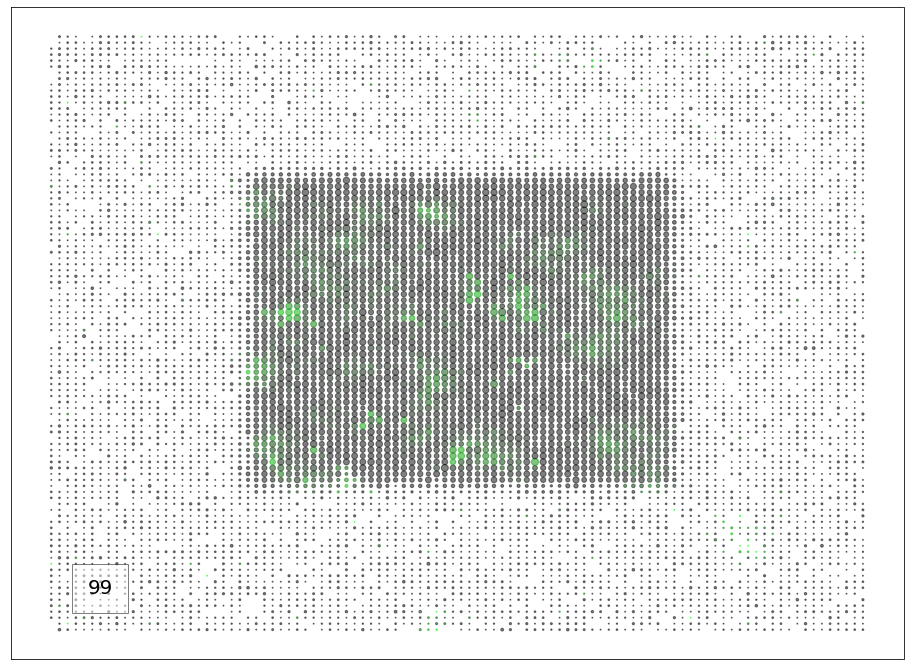

In [11]:
import matplotlib.animation as animation
from IPython.display import HTML

健康曲线 = []
感染曲线 = []
康复曲线 = []
病亡曲线 = []
医院曲线 = []
方舱曲线 = []
资源曲线 = []
隔离曲线 = []
防控状态 = False

if LOG_LEVEL >= 1:
    aaa=bbb=0

def update(t):
    global 资源总量
    global 防控状态
    global 防控力度
    global 出行意愿
    global 接触比例
    global 入院意愿
    print(t, end='.')
    
    if LOG_LEVEL >= 1:
        global aaa,bbb
        aaa=bbb=0
    if LOG_LEVEL >= 2:
        global ttt
        ttt=t+3

    for h in 总人员列表:
        h.当日密接人群 = []
        h.消耗()
    for h in 总人员列表:
        h.隔离()
    for h in 总人员列表:
        h.出行()
    for h in 总人员列表:
        h.接触()
    for h in 总人员列表:
        if h.传染性:
            h.传染()
    for h in 总人员列表:
        h.病情发展()

    if LOG_LEVEL >= 1:
        print(f'隔离中{aaa}, 非隔离{bbb}')

    jk = gr = kf = bw = fb = gl = 0
    for h in 总人员列表:
        if h.身体状况 == '健康':
            jk += 1
        elif h.身体状况 == '潜伏' or h.身体状况 == '发病' or h.身体状况 == '重症':
            gr += 1
            if h.身体状况 != '潜伏':
                fb += 1
        elif h.身体状况 == '康复':
            kf += 1
        elif h.身体状况 == '病亡':
            bw += 1
            资源总量 -= 100

        if h.隔离中:
            gl += 1
    
    if LOG_LEVEL >= 1:
        print(f'隔离人数{gl}, 感染人数{gr}')
    
    健康曲线.append(jk)
    感染曲线.append(gr)
    康复曲线.append(kf)
    病亡曲线.append(len(病亡人员列表))
    医院曲线.append(len(住院人员列表))
    方舱曲线.append(len(方舱人员列表))
    隔离曲线.append(gl)

    if 防控状态:
        # 防控状态下资源消耗
        资源总量 -= len(总人员列表) * 0.2
        # 无发病时解除
        if fb == 0:
            print('防控状态解除。', end='')
            防控状态 = False
            防控力度 = 0.1
            出行意愿 = 0.9
            接触比例 = 0.9
            入院意愿 = 0.1
    else:
        # 非防控状态下随机新增
        if 随机新增感染 and random.random() < 0.3:
            random.choice(总人员列表).被传染()
        # 超过警戒人数开启防控
        if fb > 警戒人数:
            print('进入防控状态!', end='')
            防控状态 = True
            防控力度 = 0.9
            出行意愿 = 0.1
            接触比例 = 0.1
            入院意愿 = 1
    
    资源曲线.append(资源总量)
        
    for i in range(区域大小):
        for j in range(区域大小):
            count = len(区域分布列表[i][j])
            sizes[i*区域大小+j] = count
            感染人数 = 0
            康复人数 = 0
            for h in 区域分布列表[i][j]:
                if h.已感染:
                    感染人数 += 1
                elif h.身体状况 == '康复':
                    康复人数 += 1
            if count > 0:
                colors[i*区域大小+j] = '#%s%s00' % ('{:02x}'.format(int(感染人数 / count * 255)),
                                                   '{:02x}'.format(int(康复人数 / count * 255)))
            else:
                colors[i*区域大小+j] = '#000000'

    # 标记测试人
#     colors[:] = '#999999'
#     colors[总人员列表[0].x*区域大小 + 总人员列表[0].y] = '#ff0000'
#     colors[总人员列表[1].x*区域大小 + 总人员列表[1].y] = '#00ff00'
#     colors[总人员列表[2].x*区域大小 + 总人员列表[2].y] = '#0000ff'
#     sizes[总人员列表[0].x*区域大小 + 总人员列表[0].y] = 50
#     sizes[总人员列表[1].x*区域大小 + 总人员列表[1].y] = 50
#     sizes[总人员列表[2].x*区域大小 + 总人员列表[2].y] = 50

#     if t < 9:
#         print('发病:',gr)
#         for p in 总人员列表:
#             if p.身体状况=='发病':
#                 print(p)
#                 for pp in p.密接人群:
#                     print(len(pp),end=',')
        
#         print('隔离',len([p for p in 总人员列表 if p.隔离中]))
#         print('----------------------')

    sc.set_sizes(sizes)
    sc.set_color(colors)
    title.set_text(t)

    return sc,

sizes = np.zeros(区域大小*区域大小)
for i in range(区域大小):
    for j in range(区域大小):
        sizes[i*区域大小+j] = len(区域分布列表[i][j])
colors = np.zeros(区域大小*区域大小, dtype='U7')
colors[:] = '#000000'
fig, ax = plt.subplots(figsize=(16, 12))
plt.xticks([])
plt.yticks([])

title = ax.text(0.1, 0.1, '', bbox={'facecolor':'w', 'alpha':0.5, 'pad':15},
                transform=ax.transAxes, ha="center", fontsize=20)
sc = ax.scatter(x, y, s=sizes, c=colors, alpha=0.5)
ani = animation.FuncAnimation(fig, update, frames=模拟天数, interval=200, blit=True, repeat=False)
# HTML(ani.to_html5_video())
ani.save(f'output/{ExpNo}-1.mp4')
fig.savefig(f"output/{ExpNo}-1.png")

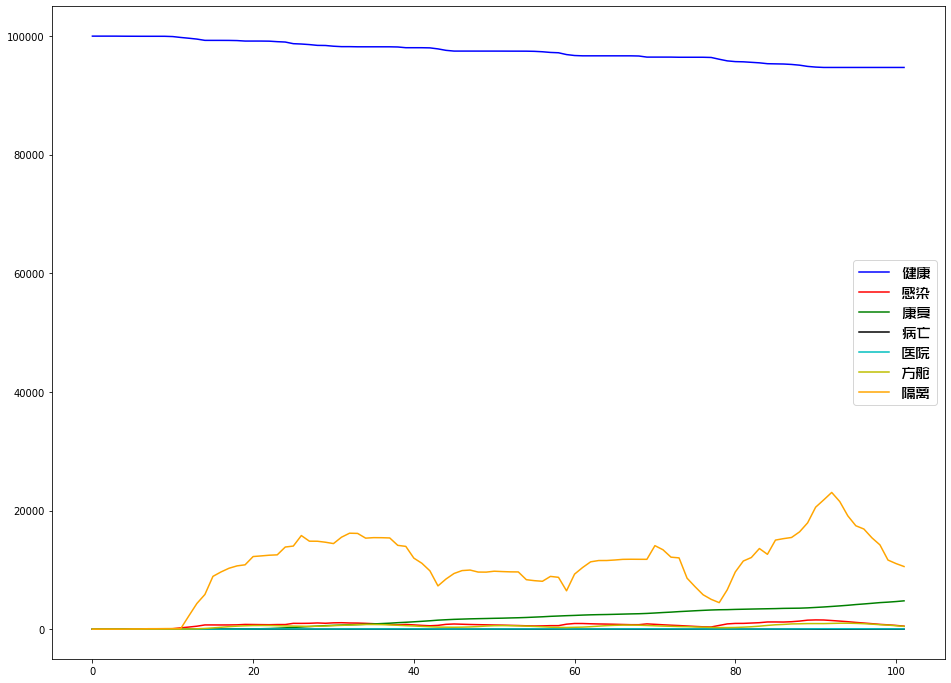

In [12]:
# 绘制曲线图
from pylab import mpl
font = mpl.font_manager.FontProperties(fname='../zhaozi.ttf', size=15)

plt.figure(figsize=(16, 12))
plt.plot(健康曲线, 'b')
plt.plot(感染曲线, 'r')
plt.plot(康复曲线, 'g')
plt.plot(病亡曲线, 'k')
plt.plot(医院曲线, 'c')
plt.plot(方舱曲线, 'y')
plt.plot(隔离曲线, 'orange')
# plt.plot(资源曲线, 'm')
plt.legend(['健康', '感染', '康复', '病亡', '医院', '方舱', '隔离', '资源'], prop=font)
plt.show()

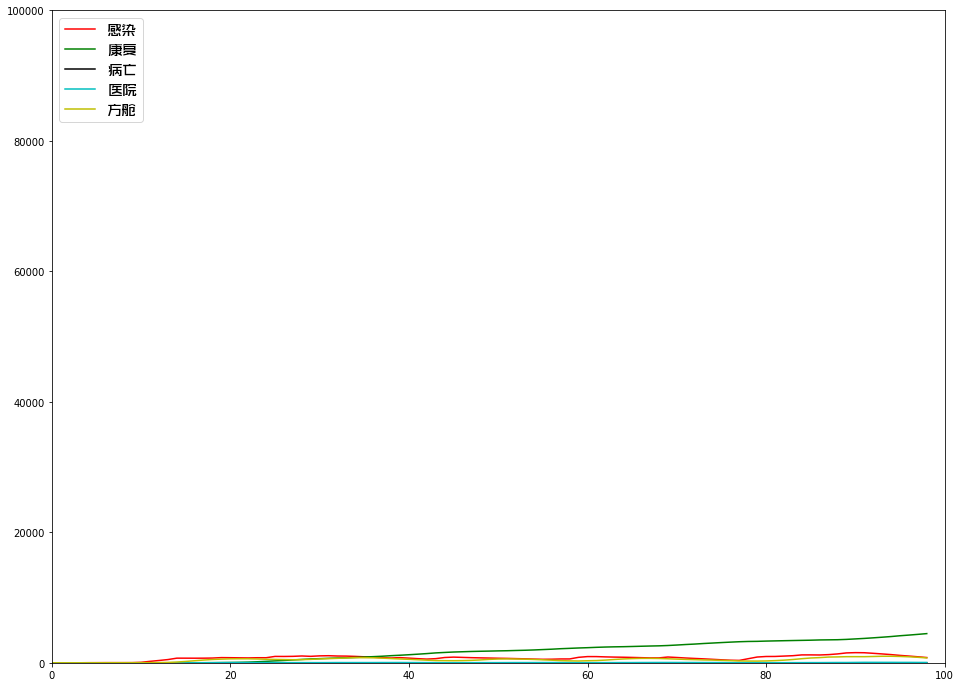

In [13]:
fig2, ax2 = plt.subplots(figsize=(16, 12))

plt.xlim((0, 100))
plt.ylim((0, 100000))

line2, = ax2.plot(感染曲线, 'r')
line3, = ax2.plot(康复曲线, 'g')
line4, = ax2.plot(病亡曲线, 'k')
line5, = ax2.plot(医院曲线, 'c')
line6, = ax2.plot(方舱曲线, 'y')

ax2.legend(['感染', '康复', '病亡', '医院', '方舱'], prop=font, loc=2)

def go(t):
    line2.set_data(range(t), 感染曲线[:t])
    line3.set_data(range(t), 康复曲线[:t])
    line4.set_data(range(t), 病亡曲线[:t])
    line5.set_data(range(t), 医院曲线[:t])
    line6.set_data(range(t), 方舱曲线[:t])
    return line2, line3, line4, line5, line6

ani2 = animation.FuncAnimation(fig2, go, frames=模拟天数, interval=100, blit=True, repeat=False)
HTML(ani2.to_html5_video())       # 网页显示视频
# ani2.save(f'output/{ExpNo}-2.mp4')
# fig2.savefig(f"output/{ExpNo}-2.png")

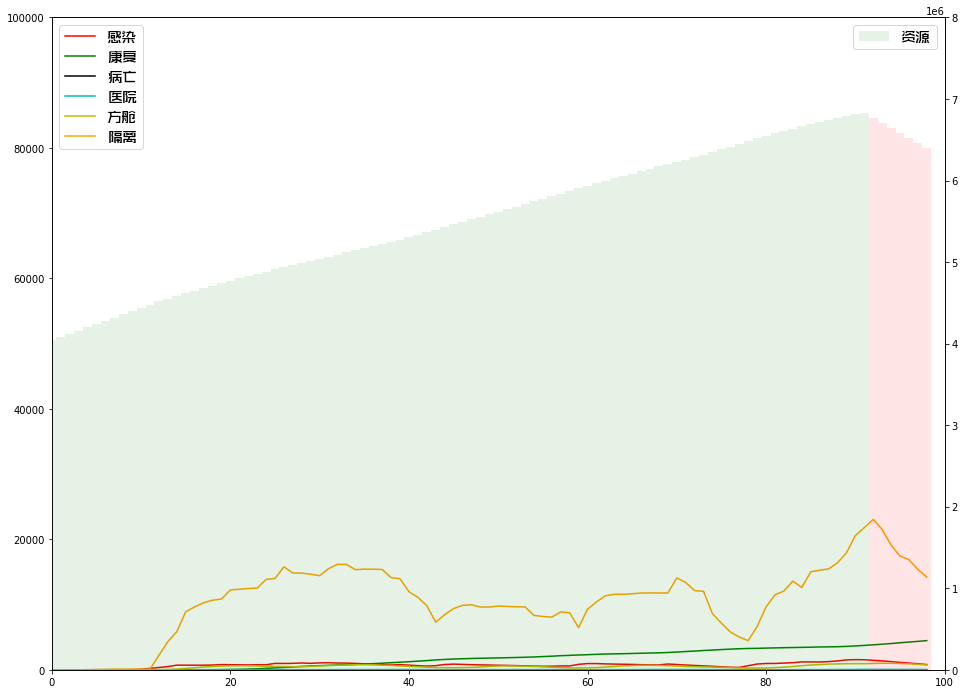

In [14]:
fig2, ax2 = plt.subplots(figsize=(16, 12))

plt.xlim((0, 100))
plt.ylim((0, 100000))

line2, = ax2.plot(感染曲线, 'r')
line3, = ax2.plot(康复曲线, 'g')
line4, = ax2.plot(病亡曲线, 'k')
line5, = ax2.plot(医院曲线, 'c')
line6, = ax2.plot(方舱曲线, 'y')
line7, = ax2.plot(隔离曲线, 'orange')

ax2.legend(['感染', '康复', '病亡', '医院', '方舱', '隔离'], prop=font, loc=2)

ax1 = ax2.twinx()
plt.ylim((0, 8000000))
bar7 = ax1.bar(x=range(len(资源曲线)), height=0, width=1, alpha=0.1, color='g', linewidth=0)
ax1.legend(['资源'], prop=font, loc=1)

def go(t):
    line2.set_data(range(t), 感染曲线[:t])
    line3.set_data(range(t), 康复曲线[:t])
    line4.set_data(range(t), 病亡曲线[:t])
    line5.set_data(range(t), 医院曲线[:t])
    line6.set_data(range(t), 方舱曲线[:t])
    line7.set_data(range(t), 隔离曲线[:t])
    for i, b in enumerate(bar7[:t]):
        b.set_height(资源曲线[i])
        if i > 0 and 资源曲线[i] < 资源曲线[i-1]:
            b.set(color='r')
    return line2, line3, line4, line5, line6, line7

ani2 = animation.FuncAnimation(fig2, go, frames=模拟天数, interval=100, blit=True, repeat=False)
HTML(ani2.to_html5_video())       # 网页显示视频
# ani2.save(f'output/{ExpNo}-3.mp4')
# fig2.savefig(f"output/{ExpNo}-3.png")

In [15]:
print(康复曲线[-1], 病亡曲线[-1], '%.3f' % (病亡曲线[-1]/(康复曲线[-1] + 病亡曲线[-1])))
print(感染曲线[-1]+病亡曲线[-1]+康复曲线[-1])

4775 1 0.000
5283
